# Assignment 3
## Problem 5
### Subrat Prasad Panda, CS1913

Design your own SVM which can solve a non-linearly separable overlapped
multi-class problem. You may use an available optimization problem solver. You are encouraged to
choose a kernel and parameter on your own. Now show the 5-fold cross validated performance of your
SVM in the following cases.

- Download the Iris flower dataset and train your SVM on class 1 and 3. What is the test performance? Can you show the learned decision boundary for a certain fold if the third and forthfeature of the dataset is used? As the problem is linearly separable you may consider a linear SVM which does not use a kernel.
- Now train your SVM to classify all three classes of the Iris dataset. What is the average test accuracy? Remember the classes are overlapped in nature.
- Create a subset of the MNIST dataset (consider only the training set) by uniformly sampling (without replacement) 500 points from each classes. Can you train your SVM on such a dataset? What is the average accuracy on such a dataset?

In [1]:
# Optimisation
import cvxopt
import cvxopt.solvers

# Math
import numpy as np
from numpy import linalg

#Data processing
from sklearn.model_selection import KFold
import csv

# Plotting
import matplotlib
import matplotlib.pyplot as plt

### CVXOPT Library
The CVXOPT library solves the Wolfe dual soft margin constrained optimisation with the following form:
$$ \underset{\alpha}{min} \frac{1}{2} \alpha^T (yy^TK) \alpha - 1^T \alpha $$
$$s.t. -\alpha_n \preceq 0, y.\alpha = 0$$
Where for CVOPT the variables will be,
- K: is the Gram matrix of all possible do products of vector $x_n$.
- P: $(yy^TG)$ matrix of size N X N
- q: $-1^T$ a vector of size N X 1
- G: -diag[1] a diagonal matrix of -1 of size N X N
- h: 0 vector of size N X 1
- b: 0 a scalar
- A: y label vector of size N X 1
- N: Number of samples points

The P, q, G, A and h will be used to call CVOPT API. The $\alpha$ is the Langragian variable

In [2]:
class svm():

    def __init__(self, kernel='linear', C=0.0, gamma=1.0, degree=3):
        self.C = C #Hyperparameter, C=0 means Hard SVM
        self.gamma = gamma #Gaussian Kernel Multimpier 1/sigma
        self.degree = degree #Degree of Polynomial kernel
        self.kernel = kernel #type of kernel

    def linear_kernel(self, x, y):
        return np.dot(x, y)

    def poly_kernel(self, x, y, degree=3):
        return (np.dot(x, y) + 1) ** degree

    def rbf_kernel(self, x, y, gamma=0.5):
        return np.exp(-gamma*linalg.norm(x - y) ** 2 )
    
    # Compute the kernel matrix K
    def compute_kernel(self, X):
        n_samples, n_features = X.shape
        # Gram matrix or Kernel trick.
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                if self.kernel == 'linear':
                    K[i, j] = self.linear_kernel(X[i], X[j])
                if self.kernel=='rbf':
                    K[i, j] = self.rbf_kernel(X[i], X[j], self.gamma)   # Kernel trick.
                    self.C = None   # Not used in gaussian kernel.
                if self.kernel == 'poly':
                    K[i, j] = self.polyn_kernel(X[i], X[j], self.degree)
        return K


    def train(self, X, y):
        n_samples, n_features = X.shape
        K =  self.compute_kernel(X) #Kernel Matrix
        # Converting into cvxopt format:
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None or self.C==0: # For C=0, it's Hard margin SVM
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else: # Restricting the langragina variable (alpha) with parameter C.
            G = cvxopt.matrix(np.vstack((np.identity(n_samples) * -1, np.identity(n_samples)))) # 0 <= alpha <= C
            h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C))) #[0, 0 , C ,C]

        # Setting options of solver:
        cvxopt.solvers.options['show_progress'] = False
        cvxopt.solvers.options['abstol'] = 1e-10 # (10^-10) very small number
        cvxopt.solvers.options['reltol'] = 1e-10
        cvxopt.solvers.options['feastol'] = 1e-10

        # Solve QP problem:
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        #Solutions
        # Lagrange multipliers: Vector on N multipliers
        alphas = np.ravel(solution['x']) # Flatten the matrix into a vector of all the Langrangian multipliers.

        # Support vectors have non zero lagrange multipliers
        sv = alphas > 1e-5 #False and True vector showing the support vectors
        index_sv = np.arange(len(alphas))[sv] #index of support vectors
        
        #Store alpha values and support vector values
        self.alphas = alphas[sv] #values of support vectors
        self.sv = X[sv] #Store support vectors
        self.sv_y = y[sv] #store class of support vectors

        # Bias(b of Wx+b):
        self.b = 0
        for n in range(len(self.alphas)): # For all support vectors:
            self.b += self.sv_y[n]
            self.b -= np.sum(self.alphas * self.sv_y * K[index_sv[n], sv])
        self.b = self.b / len(self.alphas)
        
         # Weight vector
        if self.kernel == 'linear':
            self.w = np.zeros(n_features)
            for n in range(len(self.alphas)):
                self.w += self.alphas[n] * self.sv_y[n] * self.sv[n]
        print("Training Done!")


    def predict(self, X): # Calculates the hypothesis
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            value = 0
            for a, sv_y, sv in zip(self.alphas, self.sv_y, self.sv): # a : Lagrange multipliers, sv : support vectors.
                if self.kernel == 'linear':
                    value += a * sv_y * self.linear_kernel(X[i], sv)
                if self.kernel=='rbf':
                    value += a * sv_y * self.rbf_kernel(X[i], sv, self.gamma)   # Kernel trick.
                    self.C = None   # Not used in gaussian kernel.
                if self.kernel == 'poly':
                    value += a * sv_y * self.poly_kernel(X[i], sv, self.degree)

            y_predict[i] = value
        return np.sign(y_predict + self.b) #returns Hypothesis: sign(sum^S a * y * kernel + b)

X: Rows are the samples and columns are the features

y: row vector of class labels

### Testing with small example

In [3]:
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])
y = np.array([-1, -1, 1, 1]) #Row Vector
y = y.astype('float')
test = svm(kernel='linear', C=0.0, gamma=1.0, degree=3)
test.train(X, y)
y_predict = test.predict(X)
correct_predictions = np.sum(y_predict == y) #Number of correct predictions
print(f"Total Correct Predictions: {correct_predictions}")

Training Done!
Total Correct Predictions: 4


## 1. IRIS Dataset with only Class 1 and Class 3

### Read CSV IRIS data

In [4]:
#Read IRIS Dataset
data = []
with open('datasets/iris.data','r')as f:
    file = csv.reader(f)
    for row in file:
        if row[4] == 'Iris-setosa':
            row[4] = '1'
            float_list = list(map(float, row)) 
            data.append(float_list)
        
        elif row[4] == 'Iris-virginica':
            row[4] = '-1'
            float_list = list(map(float, row)) 
            data.append(float_list)

data = np.array(data)
np.random.shuffle(data) #Shuffle the input data
num_of_sample = len(data)

# #Generate Test and Training Data from the Sample 80-20%
# test_data = data[:int(num_of_sample*0.20)]
# training_data = data[int(num_of_sample*0.20):]

### Create X and y Matrix from the data

In [5]:
X = data[:,:4] # take features
y = np.ravel(data[:, -1:]) #take the class labels and flaten to make row vector

### Train and Test with 5-Folds cross validation

In [6]:
kfold = KFold(5, True, 1) # prepare 5 fold cross validation

iris1 = svm(kernel='linear')

accuracy = 0 #init mse sum with 0
for train, test in kfold.split(X):
    #kfold:True to use the z values from previous training
    iris1.train(X[train], y[train]) #train the svm
    y_predict = iris1.predict(X[test])
    correct_predictions = np.sum(y_predict == y[test]) #Number of correct predictions
    accuracy += (correct_predictions/len(y[test]))*100 #percentage accuracy

Training Done!
Training Done!
Training Done!
Training Done!
Training Done!


In [7]:
#Compute the average accuracy over 5 folds of testing
avg_accuracy = accuracy/5
print(f"Average Accuracy: {avg_accuracy}%")

Average Accuracy: 100.0%


### Plot the linear classification

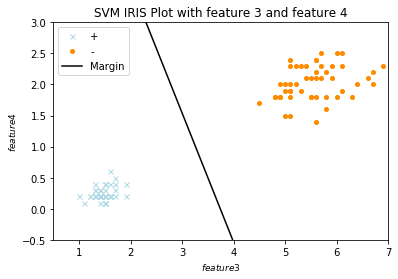

In [8]:
#prepare data for plotting
X1 = X[y == 1]
X1 = X1[:, 2:4] # +1 classes

X2 = X[y == -1]
X2 = X2[:, 2:4] # -1 classes


def compute_y(x, w, b, c = 0): #coordinate (x1, x2)
    return ( (5.8*w[0] + 3*w[1] + w[2] * x + b - c) / -w[3] ) #w.X1 + b = c
    # 5.8 and 3 is the average of feature1 and feature2


fig = plt.figure()  # create a figure object
ax = fig.add_subplot(1, 1, 1)
# Format plot area:
ax = plt.gca()

ax.set_axisbelow(True)
x1_min, x1_max = X1.min(), X1.max()
x2_min, x2_max = X2.min(), X2.max()
# ax.set(xlim=(x1_min, x1_max), ylim=(x2_min, x2_max))

# Labels
plt.xlabel('$feature 3$', fontsize=9)
plt.ylabel('$feature 4$', fontsize=9)

# Add the plots:
plt.plot(X1[:, 0], X1[:, 1], marker='x',markersize=5, color='lightblue',linestyle='none', label="+")
plt.plot(X2[:, 0], X2[:, 1], marker='o',markersize=4, color='darkorange',linestyle='none', label="-")

# #Plot Support vectors
# plt.scatter(iris1.sv[:, 2], iris1.sv[:, 3], s=60, color="blue")   

w = iris1.w
b = iris1.b
x1_min, x1_max = ax.get_xlim()

y1 = compute_y(x1_min, w, b)
y2 = compute_y(x1_max, w, b)
plt.plot([x1_min, x1_max], [y1, y2], "k", label = 'Margin') #Plot Margin

# # Margin +: w.x + b = 1
# y3 = compute_y(x1_min, w, b, 1)
# y4 = compute_y(x1_max, w, b, 1)
# plt.plot([x1_min, x1_max], [y3, y4], "k--")

# # Margin -: w.x + b = -1
# y5 = compute_y(x1_min, w, b, -1)
# y6 = compute_y(x1_max, w, b, -1)
# plt.plot([x1_min, x1_max], [y5, y6], "k--")

plt.xlim([0.5, 7])
plt.ylim([-0.5, 3])
plt.legend()
plt.title("SVM IRIS Plot with feature 3 and feature 4")
plt.show()

## 2. IRIS Data with all classes
One vs all Method is used

For IRIS Setosa

In [9]:
#Read IRIS Dataset
data1 = []
with open('datasets/iris.data','r') as f:
    file = csv.reader(f)
    for row in file:
        if row[4] == 'Iris-setosa':
            row[4] = '1'
            float_list = list(map(float, row)) 
            data1.append(float_list)
        else: #Iris-virginica 'Iris-versicolor' # 'Iris-setosa'
            row[4] = '-1'
            float_list = list(map(float, row)) 
            data1.append(float_list)

data1 = np.array(data1)
X = data1[:,:4] # take features
y = np.ravel(data1[:, -1:]) #take the class labels and flaten to make row vector

iris2_1 = svm(kernel='rbf')
iris2_1.train(X, y) #train the svm
y_predict1 = iris2_1.predict(X)
correct_predictions = np.sum(y_predict1 == y) #Number of correct predictions
accuracy1 = (correct_predictions/len(y))*100 #percentage accuracy
print(f"Accuracy: {accuracy1}%")

Training Done!
Accuracy: 100.0%


Classifier 2

In [10]:
#Read IRIS Dataset
data1 = []
with open('datasets/iris.data','r') as f:
    file = csv.reader(f)
    for row in file:
        if row[4] == 'Iris-virginica':
            row[4] = '1'
            float_list = list(map(float, row)) 
            data1.append(float_list)
        else: #Iris-virginica 'Iris-versicolor' # 'Iris-setosa'
            row[4] = '-1'
            float_list = list(map(float, row)) 
            data1.append(float_list)

data1 = np.array(data1)
X = data1[:,:4] # take features
y = np.ravel(data1[:, -1:]) #take the class labels and flaten to make row vector

iris2_2 = svm(kernel='rbf')
iris2_2.train(X, y) #train the svm
y_predict2 = iris2_2.predict(X)
correct_predictions = np.sum(y_predict2 == y) #Number of correct predictions
accuracy2 = (correct_predictions/len(y))*100 #percentage accuracy
print(f"Accuracy: {accuracy2}%")

Training Done!
Accuracy: 100.0%


Classifier 3

In [11]:
data1 = []
with open('datasets/iris.data','r') as f:
    file = csv.reader(f)
    for row in file:
        if row[4] == 'Iris-versicolor':
            row[4] = '1'
            float_list = list(map(float, row)) 
            data1.append(float_list)
        else: #Iris-virginica 'Iris-versicolor' # 'Iris-setosa'
            row[4] = '-1'
            float_list = list(map(float, row)) 
            data1.append(float_list)

data1 = np.array(data1)
X = data1[:,:4] # take features
y = np.ravel(data1[:, -1:]) #take the class labels and flaten to make row vector

iris2_3 = svm(kernel='rbf')
iris2_3.train(X, y) #train the svm
y_predict3 = iris2_3.predict(X)
correct_predictions = np.sum(y_predict3 == y) #Number of correct predictions
accuracy3 = (correct_predictions/len(y))*100 #percentage accuracy
print(f"Accuracy: {accuracy3}%")

Training Done!
Accuracy: 100.0%


### Aggegrate all the prediction data from 3 (one vs all) classifiers

In [12]:
y_result = [0] * len(y)
for row in range(len(y)):
    if y_predict1[row] == 1:
        y_result[row] = "Iris-setosa"
    if y_predict2[row] == 1:
        y_result[row] = "Iris-virginica"
    if y_predict3[row] == 1:
        y_result[row] = "Iris-versicolor"

In [13]:
#Read IRIS Dataset
correct_predictions = 0
i = 0
with open('datasets/iris.data','r')as f:
    file = csv.reader(f)
    for row in file:
        if y_result[i] == row[4]:
            correct_predictions +=1
        i +=1

accuracy4 = (correct_predictions/len(y_result))*100 #percentage accuracy
print(f"Accuracy of Final Prediction: {accuracy4}%")

Accuracy of Final Prediction: 100.0%


#### The prediction after 3 classifiers is found to be 100% using RBF kernel

Problem 3: MNIST dataset can similarly be trained, there 10 classifiers need to be used for one vs all.